## HOTOSM Road Classification
In this notebook, we will try to classify the road conditions as paved and unpaved using the street level images collected from the
Mapillary project.

For the classification, we will train a convolutional neural network architecture called MobileNet which is a light weight model, usually deployed in edge devices. 

In [101]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import onnx
import tf2onnx
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input, GlobalAveragePooling2D

### Exploratory data analysis
Let's take a look at the data first. The data for this road classification exist in 2 folders, paved and unpaved.

In [49]:
! ls /Users/savin/Omdena-Projects/HOTOSM/data/Roads-Classification/Paved/ | head -10

0.jpg
1.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
16.jpg
17.jpg
18.jpg


Now let's collect the filepath of files in each folder and their labels to a pandas dataframe.

Number of files in Unpaved folder:  423
Number of files in Paved folder:  288


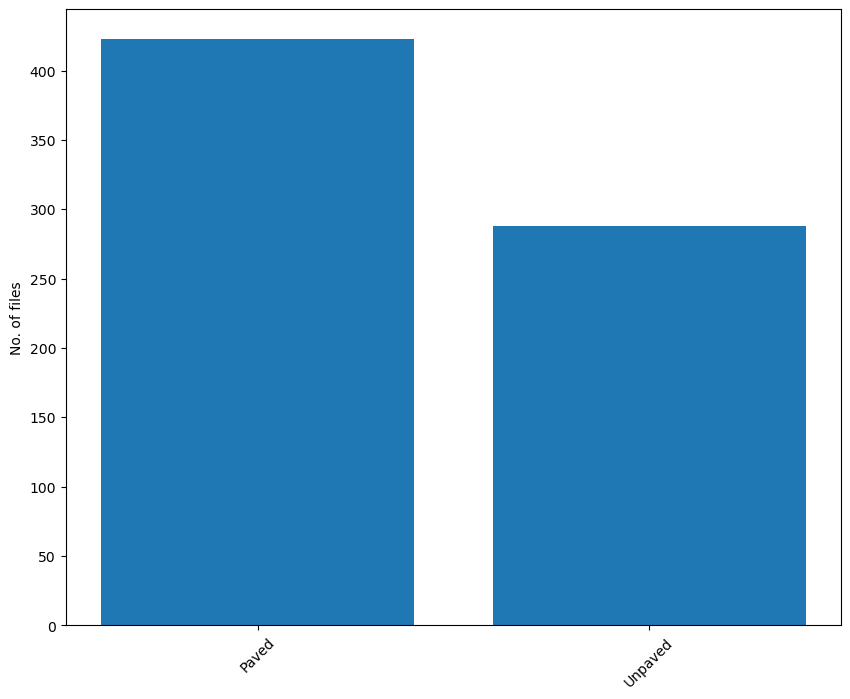

In [51]:
# Directory containing the data
data_path = "/Users/savin/Omdena-Projects/HOTOSM/data/Roads-Classification/"

# Listing number of image files in each folder list
folds = [item for item in  os.listdir(data_path) if os.path.isdir(data_path+item)] # image directories
file_len = np.zeros(len(folds)) # Number of files in each folder

# Collecting the filepath of each files and their associated folder labeling
# Will be used for train and test split of the data
image_filepath = []
labels = []

for i,fold in enumerate(sorted(folds)):
    files = glob.glob(data_path+fold+"/*.jpg")
    nfiles = len(files)
    file_len[i] = nfiles
    for filepath in files:
        image_filepath.append(filepath)
        labels.append(i)

print(f"Number of files in {folds[0]} folder: {file_len[0]: 0.0f}")
print(f"Number of files in {folds[1]} folder: {file_len[1]: 0.0f}")

# saving the information into a pandas dictionary
df = pd.DataFrame.from_dict({'X_path':image_filepath, 'Y':labels})
df = df.sample(frac=1) # shuffling the data

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(sorted(folds), file_len)
ax.set_ylabel("No. of files")
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

Now Let's read the images in these folders into a numpy array which we can use for modelling. But before that we need to make sure if all of these images have the same dimensions.

#### Data Splitting to train and test
Before loading the data, let's split the data into train and test. Since we have a limited amount of images, we are splitting into cross validation datasets.

In [53]:
df.head(10)

,X_path,Y
625,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,1
471,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,1
310,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,0
363,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,0
40,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,0
16,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,0
618,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,1
353,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,0
393,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,0
704,/Users/savin/Omdena-Projects/HOTOSM/data/Roads...,1


In [54]:
# stratisfied splitting the data into 80% train and 20 % test to ensure that the test data contains 
# more or less equal distributions of different classes
X_train_path, X_test_path, Y_train, Y_test = train_test_split(df['X_path'], df['Y'], test_size=0.2, random_state=42, stratify = df['Y'])
print(Y_train.shape, Y_test.shape)

(568,) (143,)


### Preprocessing
We will try to get the metdata of the images to understand the dimension of the images. If they are different we need to resize them before feeding into CNN algorithms.

In [56]:
# Let's try to get the metadata information from the image files without reading them in memory using the Pillow package

h = [] # height
w = [] # width

for i, filepath in enumerate(df['X_path']):
    img = Image.open(filepath)
    width, height = img.size
    h.append(height)
    w.append(width)

print(np.unique(np.array(h)))
print(np.unique(np.array(w)))

[ 648  659  672  782 1067 1290 1575 1611 1641 1648 1673 1732 1776 1864
 1914 1915 1940 2028 2292 2433 2448 3000 3008 3024]
[1152 1158 1169 1179 1183 1270 1279 1428 1739 2060 2250 2521 2594 2682
 2704 2711 2761 2922 2984 3035 3090 3264 3357 3529 4000 4032 5344]


Interestingly, the dimensions of the images varies a lots as they are collected through different sources. Let's resize all the images to (224 by 160), which are the acceptable image dimensions of the DL models.

In [58]:
# Let's read the image file into a numpy array
#dimensions of the resized image
width, height = [224, 160]

def load_data(df):
    """
    Returns the array with loaded images from
    the image files
    args:
    df : dataframe containing the filepaths
    """
    samp = df.shape[0]
    #print(samp)
    data = np.zeros((samp, height, width, 3), dtype = np.float32) # Each image with width, height and 3 RGB channels
    for i in range(samp):
        filename = df.iloc[i]
        
        # Load the image
        img = cv2.imread(filename)
        
        if img is not None:
            img_resized = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA) # resize the images
            data[i,:,:,:] = img_resized/255 # Normalize the pixel values
        else:
            print("Image cannot be opened or read")

    return data        

In [59]:
# Get the train data and test data

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)

print(f" X train shape : {X_train.shape}")
print(f"X test shape : {X_test.shape}")

 X train shape : (568, 160, 224, 3)
X test shape : (143, 160, 224, 3)


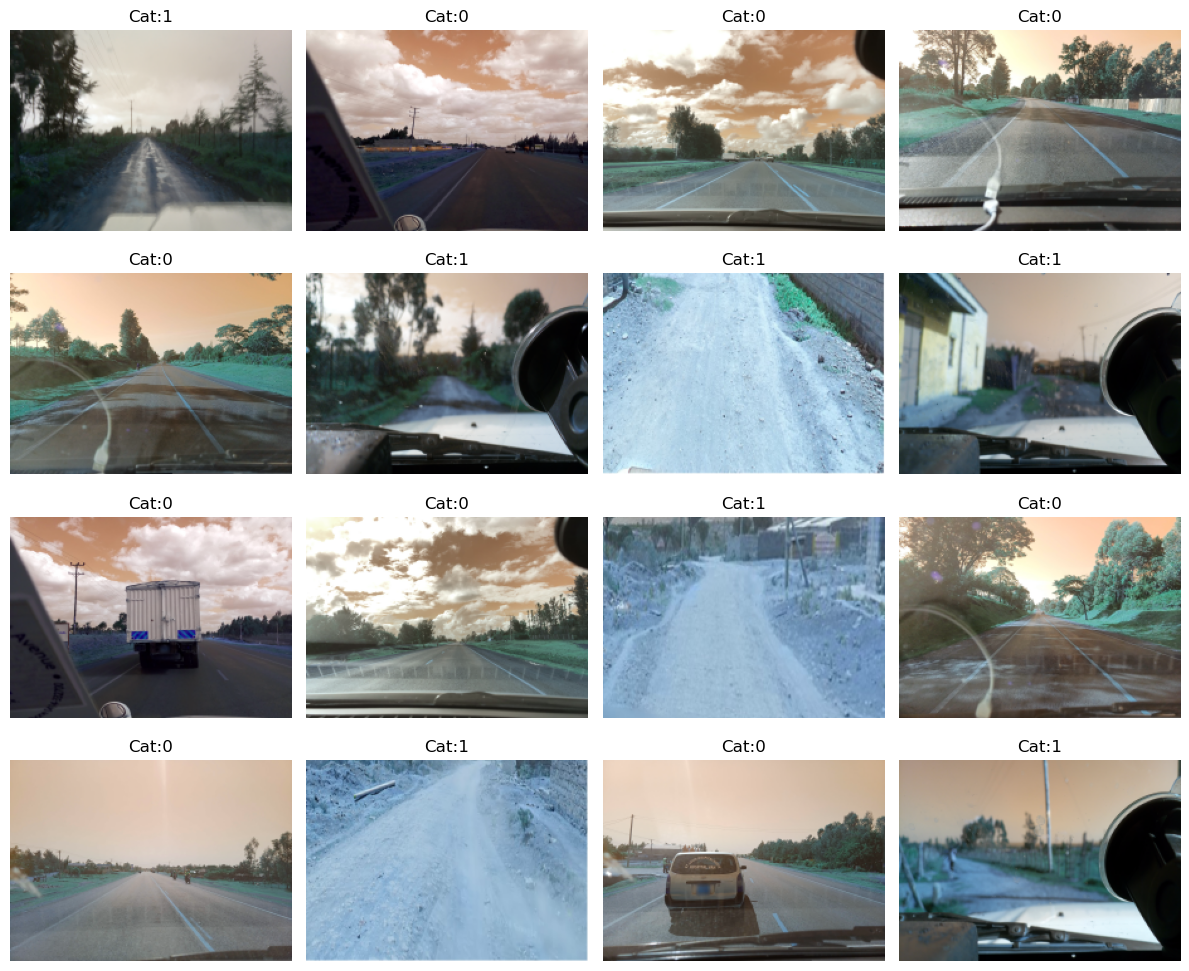

In [60]:
# Let's plot a random image files to see the collected data
fig, axs = plt.subplots(4, 4, figsize=(12,10), tight_layout = True)
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].imshow(X_train[i, :, :, :])
    axs[i].set_title(f"Cat:{Y_train.iloc[i]}")
    axs[i].axis("off")
plt.show()

The class: 0  is paved and class:1 is unpaved.

## Modeling of data
For modeling, we will try the MobileNetV2 model. This model utilizes a combination of the bottleneck units which uses a combination of expansion, depthwise seperated convolution and projection) along with residual units to improve the model performance.

In [63]:
# import the tensorflow model here
from tensorflow.keras.applications import MobileNetV2

# Let's create a function for the model

def call_mobilenet(input_shape):
    
    # Calling the Resnet model
    mob_model = MobileNetV2(
    include_top=False, # remove the top layer or the classification layer (1000 classes from imagenet training)
    weights="imagenet", # utilize imagenet weights
    input_tensor=None,
    input_shape=input_shape, # time steps axis not needed here
    pooling=None)  # no pooling mentioned

    #print a summary of the base model
    mob_model.summary()

    nb_layers = len(mob_model.layers)
    print(f"No. of MobileNetV2 model layers: {nb_layers}")

    # Freeze the base model as we wan to use the pretrained weights
    mob_model.trainable = False

    return mob_model

def create_model(input_shape, nclass):

    """
    Function returns the model output
    Args:
    input shape: shape of the input train/test data (excluding the batch size)
    nclass: number of output classes
    """
    # start the model
    model = Sequential()

    # defining the input layer
    model.add(Input(shape=input_shape))

    # resnet layer for feature extraction
    model.add(call_mobilenet(input_shape)) # calling the mobilenet function here

    # adding a 2D global average to reduce the size and summarize the info in each channel
    model.add(GlobalAveragePooling2D())
    
    # flattening  not needed anymore with the global averaging
    
    # Drop out regularization
    model.add(Dropout(0.2))
              
    # fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    
    # Final output layer, Binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model

In [64]:
nclass = len(np.unique(Y_train))
input_shape = X_train.shape[1:] 
print(input_shape, nclass)

(160, 224, 3) 2


In [65]:
# Create the model
mob_netv2 = create_model(input_shape, nclass)
# This will print out the basic MobileNetV2 architecture 

2025-04-21 18:34:15.597848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 112, 32)  864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 112, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 112, 32)  0           ['bn_Conv1[0][

In [66]:
# Print out the overall model summary
mob_netv2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 16)                1

In [67]:
# compiling process
mob_netv2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [68]:
hist_mobnetv2 = mob_netv2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data = (X_test, Y_test))

Epoch 1/10
18/18 [==============================] - 5s 202ms/step - loss: 0.2742 - accuracy: 0.8732 - val_loss: 0.0721 - val_accuracy: 0.9790
Epoch 2/10
18/18 [==============================] - 3s 180ms/step - loss: 0.0184 - accuracy: 0.9965 - val_loss: 0.0411 - val_accuracy: 0.9860
Epoch 3/10
18/18 [==============================] - 3s 168ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 0.0178 - val_accuracy: 0.9860
Epoch 4/10
18/18 [==============================] - 3s 149ms/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0.0241 - val_accuracy: 0.9860
Epoch 5/10
18/18 [==============================] - 3s 147ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 0.9860
Epoch 6/10
18/18 [==============================] - 3s 145ms/step - loss: 0.0027 - accuracy: 0.9982 - val_loss: 0.0220 - val_accuracy: 0.9930
Epoch 7/10
18/18 [==============================] - 3s 148ms/step - loss: 4.8757e-04 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9930
Ep

/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_98457/1284852736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_98457/1284852736.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

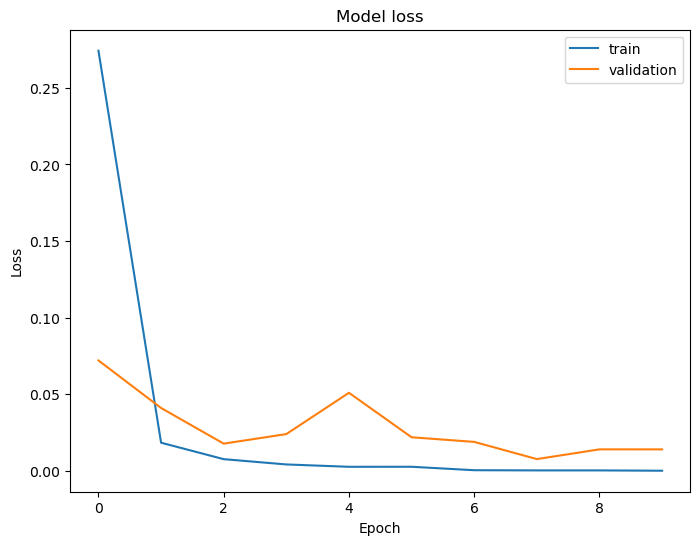

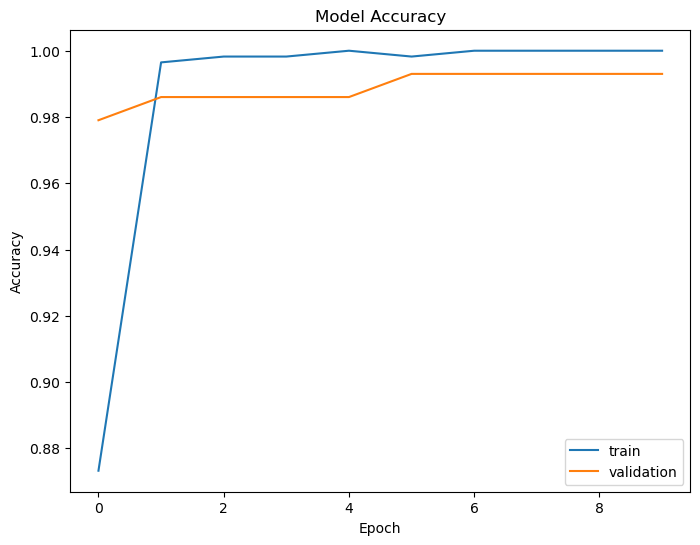

In [69]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 

df_loss_acc = pd.DataFrame(hist_mobnetv2.history)

# losses data frame
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

# accuracy data frame
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

# plotting the loss and accuracy
df_loss.plot(title='Model loss',figsize=(8,6)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(8,6)).set(xlabel='Epoch',ylabel='Accuracy')

In [70]:
ypred_train_mob = mob_netv2.predict(X_train)
ypred_train_mob[ypred_train_mob > 0.5] = 1
ypred_train_mob[ypred_train_mob < 0.5] = 0

ypred_test_mob = mob_netv2.predict(X_test)
ypred_test_mob[ypred_test_mob > 0.5] = 1
ypred_test_mob[ypred_test_mob < 0.5] = 0

print("Training data:")
print(f" Precision : {precision_score(Y_train, ypred_train_mob)}, Recall: {recall_score(Y_train, ypred_train_mob)},F1-score:{f1_score(Y_train, ypred_train_mob)}")

print("Test data:")
print(f" Precision : {precision_score(Y_test, ypred_test_mob)}, Recall: {recall_score(Y_test, ypred_test_mob)}, F1-score:{f1_score(Y_test, ypred_test_mob)}")

5/5 [==============================] - 1s 111ms/step
Training data:
 Precision : 1.0, Recall: 1.0,F1-score:1.0
Test data:
 Precision : 0.9830508474576272, Recall: 1.0, F1-score:0.9914529914529915


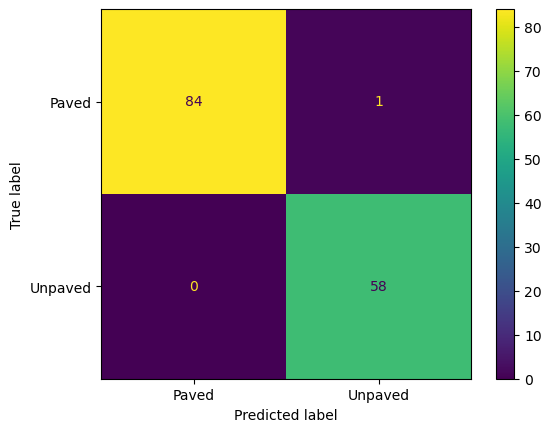

In [71]:
# Confusion matrix from the test data
ConfusionMatrixDisplay.from_predictions(Y_test, ypred_test_mob, display_labels = ['Paved','Unpaved'])
plt.show()

In [72]:
print(classification_report(Y_test, ypred_test_mob, target_names=['Paved', 'Unpaved']))

              precision    recall  f1-score   support

       Paved       1.00      0.99      0.99        85
     Unpaved       0.98      1.00      0.99        58

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



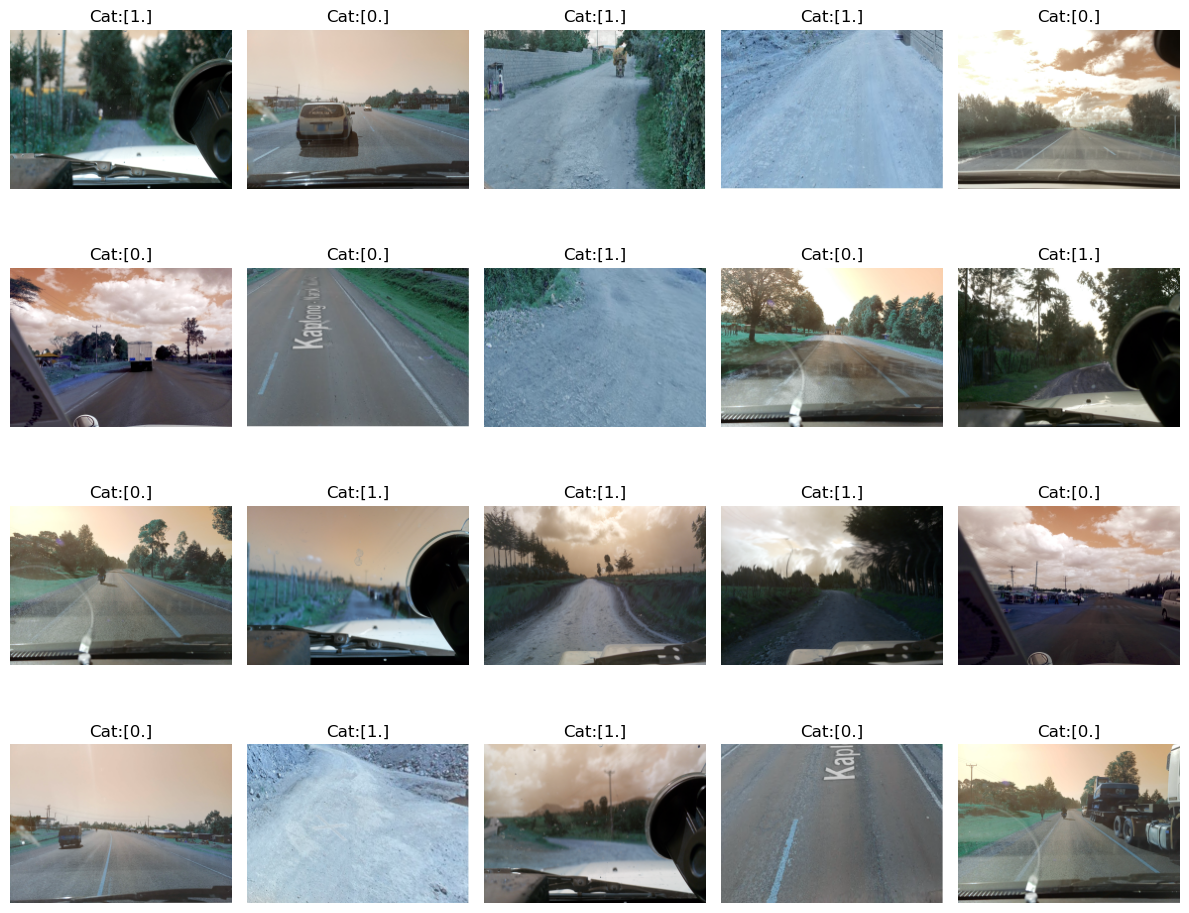

In [73]:
# Let's visualize some of the results from our modeling efforts
fig, axs = plt.subplots(4, 5, figsize=(12,10), tight_layout = True)
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].imshow(X_test[i, :, :, :])
    axs[i].set_title(f"Cat:{ypred_test_mob[i]}")
    axs[i].axis("off")
plt.show()

The models results looks really good by using the image nets. Since we are getting very accurate results with the pretrained imagenet weights, further fine tuning of the outer layers is not necessary.

In [95]:
# save the model
mob_netv2.save("mobilenet_v2-roads.h5")

In [103]:
onnx_model, _ = tf2onnx.convert.from_keras(mob_netv2)
onnx.save(onnx_model, 'mobilenet_v2-roads.onnx')

2025-04-21 18:53:41.013388: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-04-21 18:53:41.388789: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
